In [23]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .appName("Test") \
     .getOrCreate()

from pyspark import SparkContext  
sc = spark.sparkContext # Link SparkContext to SparkSession

In [85]:
import urllib.request  # lib that handles URLs
import io
import pandas as pd
pd.options.display.max_rows=250
import numpy as np
from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
#import seaborn as sns

import pyspark.sql.functions as func
from pyspark.sql.functions import col

# Get GDELT Schema

In [3]:
target_url="https://raw.githubusercontent.com/linwoodc3/gdelt2HeaderRows/master/schema_csvs/GDELT_2.0_Events_Column_Labels_Header_Row_Sep2016.csv"
data = urllib.request.urlopen(target_url).read().decode('utf8')
formats = pd.read_csv(io.StringIO(data))
colnames_events = list(formats["tableId"])

target_url="https://raw.githubusercontent.com/linwoodc3/gdelt2HeaderRows/master/schema_csvs/GDELT_2.0_eventMentions_Column_Labels_Header_Row_Sep2016.tsv"
data = urllib.request.urlopen(target_url).read().decode('utf8')
formats = pd.read_csv(io.StringIO(data),sep="\t")
colnames_mentions = list(formats.loc[:15,"0"])

target_url="https://raw.githubusercontent.com/linwoodc3/gdelt2HeaderRows/master/schema_csvs/GDELT_2.0_gdeltKnowledgeGraph_Column_Labels_Header_Row_Sep2016.tsv"
data = urllib.request.urlopen(target_url).read().decode('utf8')
formats = pd.read_csv(io.StringIO(data),sep="\t")
colnames_gkg = list(formats["tableId"])

# Dataset Imports

In [4]:
start = datetime.now()

df_events = spark.read.format("csv") \
    .option("header", "false") \
    .option("delimiter","\t") \
    .option("inferSchema", "true") \
    .load(path=["s3://gdelt-open-data/v2/events/2017*.export.csv",
                "s3://gdelt-open-data/v2/events/2018*.export.csv"])
df_events = df_events.toDF(*colnames_events)
df_events.cache()

print(df_events.count())
print(datetime.now()-start)

127869166
0:14:09.753243


In [5]:
df_events.printSchema()

root
 |-- GLOBALEVENTID: integer (nullable = true)
 |-- SQLDATE: integer (nullable = true)
 |-- MonthYear: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- FractionDate: double (nullable = true)
 |-- Actor1Code: string (nullable = true)
 |-- Actor1Name: string (nullable = true)
 |-- Actor1CountryCode: string (nullable = true)
 |-- Actor1KnownGroupCode: string (nullable = true)
 |-- Actor1EthnicCode: string (nullable = true)
 |-- Actor1Religion1Code: string (nullable = true)
 |-- Actor1Religion2Code: string (nullable = true)
 |-- Actor1Type1Code: string (nullable = true)
 |-- Actor1Type2Code: string (nullable = true)
 |-- Actor1Type3Code: string (nullable = true)
 |-- Actor2Code: string (nullable = true)
 |-- Actor2Name: string (nullable = true)
 |-- Actor2CountryCode: string (nullable = true)
 |-- Actor2KnownGroupCode: string (nullable = true)
 |-- Actor2EthnicCode: string (nullable = true)
 |-- Actor2Religion1Code: string (nullable = true)
 |-- Actor2Religion2Code: 

In [6]:
rec = pd.DataFrame(df_events.take(1))
rec.columns = colnames_events
rec.T

,0
GLOBALEVENTID,801430904
SQLDATE,20081112
MonthYear,200811
Year,2008
FractionDate,2008.85
Actor1Code,None
Actor1Name,None
Actor1CountryCode,None
Actor1KnownGroupCode,None
Actor1EthnicCode,None


In [80]:
# Import mentions
start = datetime.now()

df_mentions = spark.read.format("csv") \
    .option("header", "false") \
    .option("delimiter","\t") \
    .option("inferSchema", "true") \
    .load("s3://gdelt-open-data/v2/mentions/2018*.mentions.csv")
df_mentions = df_mentions.toDF(*colnames_mentions)
df_mentions.cache()

print(datetime.now()-start)

0:06:53.730676


In [136]:
df_mentions.count()

221183764

In [81]:
df_mentions.printSchema()

root
 |-- GLOBALEVENTID: integer (nullable = true)
 |-- EventTimeDate: long (nullable = true)
 |-- MentionTimeDate: long (nullable = true)
 |-- MentionType: integer (nullable = true)
 |-- MentionSourceName: string (nullable = true)
 |-- MentionIdentifier: string (nullable = true)
 |-- SentenceID: integer (nullable = true)
 |-- Actor1CharOffset: integer (nullable = true)
 |-- Actor2CharOffset: integer (nullable = true)
 |-- ActionCharOffset: integer (nullable = true)
 |-- InRawText: integer (nullable = true)
 |-- Confidence: integer (nullable = true)
 |-- MentionDocLen: integer (nullable = true)
 |-- MentionDocTone: double (nullable = true)
 |-- MentionDocTranslationInfo: string (nullable = true)
 |-- Extras: string (nullable = true)



In [82]:
rec_mentions = pd.DataFrame(df_events.take(1))
rec_mentions.columns = colnames_events
rec.T

,0
GLOBALEVENTID,801430904
SQLDATE,20081112
MonthYear,200811
Year,2008
FractionDate,2008.85
Actor1Code,None
Actor1Name,None
Actor1CountryCode,None
Actor1KnownGroupCode,None
Actor1EthnicCode,None


In [28]:
# Read in CAMEO code file
df_cameo = sc.textFile("s3://halogen15-nova/BigDataProject/CAMEO_codes.txt").map(lambda x: x.split(': ')).toDF(['CAMEO_code', 'CAMEO_value'])

In [29]:
df_cameo.printSchema()

root
 |-- CAMEO_code: string (nullable = true)
 |-- CAMEO_value: string (nullable = true)



In [79]:
df_cameo.show(25)

+----------+--------------------+
|CAMEO_code|         CAMEO_value|
+----------+--------------------+
|        01|MAKE PUBLIC STATE...|
|       010|Make statement, n...|
|       011|     Decline comment|
|       012|Make pessimistic ...|
|       013|Make optimistic c...|
|       014|Consider policy o...|
|       015|Acknowledge or cl...|
|       016| Deny responsibility|
|       017|Engage in symboli...|
|       018|Make empathetic c...|
|       019|      Express accord|
|        02|              APPEAL|
|       020|Make an appeal or...|
|       021|Appeal for materi...|
|      0211|Appeal for econom...|
|      0212|Appeal for milita...|
|      0213|Appeal for judici...|
|      0214|Appeal for intell...|
|       022|Appeal for diplom...|
|       023|Appeal for aid, n...|
|      0231|Appeal for econom...|
|      0232|Appeal for milita...|
|      0233|Appeal for humani...|
|      0234|Appeal for milita...|
|       024|Appeal for politi...|
+----------+--------------------+
only showing t

# Basic Plots

### Plotting functions

In [88]:
def plot_line_over_time(x,y,ylabel,filename):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(x,y)

    ax.set_xlabel("Week of Year")
    ax.tick_params(axis="x", rotation=30)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))

    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    plt.tight_layout()
    plt.savefig("Plots/"+filename+".png", 
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    
    
def counts_by_week_year(relevant_events):
    # group by day
    all_events_by_day = pd.DataFrame(relevant_events.groupby("SQLDATE").count().collect())
    all_events_by_day.columns = ["Date","Count"]
    all_events_by_day["Date"] = pd.to_datetime(all_events_by_day["Date"].astype(str), format='%Y%m%d', errors="coerce")
    all_events_by_day = all_events_by_day[all_events_by_day["Date"] >= datetime.strptime("2017-01-01","%Y-%m-%d")]
    all_events_by_day = all_events_by_day.sort_values(by="Date")

    # get week number of year
    all_events_by_day["Week"] = ((all_events_by_day["Date"].dt.dayofyear-1)//7+1).apply(lambda x: '{0:0>2}'.format(min(x,52)))
    all_events_by_day["Year"] = all_events_by_day["Date"].dt.year.astype(str)
    all_events_by_day["YearWeek"] = all_events_by_day["Year"] + "-" + all_events_by_day["Week"]
    all_events_by_day = all_events_by_day.groupby(by="YearWeek")["Count"].sum().reset_index()

    return all_events_by_day


def avg_tone_by_week_year(relevant_events):
    all_events_by_day = pd.DataFrame(relevant_events.groupby("SQLDATE").agg(func.mean("AvgTone").alias("AvgTone")).collect())
    all_events_by_day.columns = ["Date","AvgTone"]
    all_events_by_day["Date"] = pd.to_datetime(all_events_by_day["Date"].astype(str), format='%Y%m%d', errors="coerce")
    all_events_by_day = all_events_by_day[all_events_by_day["Date"] >= datetime.strptime("2017-01-01","%Y-%m-%d")]
    all_events_by_day = all_events_by_day.sort_values(by="Date")

    # get week number of year
    all_events_by_day["Week"] = ((all_events_by_day["Date"].dt.dayofyear-1)//7+1).apply(lambda x: '{0:0>2}'.format(min(x,52)))
    all_events_by_day["Year"] = all_events_by_day["Date"].dt.year.astype(str)
    all_events_by_day["YearWeek"] = all_events_by_day["Year"] + "-" + all_events_by_day["Week"]
    all_events_by_day = all_events_by_day.groupby(by="YearWeek")["AvgTone"].mean().reset_index()

    return all_events_by_day

def counts_by_day(relevant_events):
    all_events_by_day = pd.DataFrame(relevant_events.groupby("SQLDATE").count().collect())
    all_events_by_day.columns = ["Date","Count"]
    all_events_by_day["Date"] = pd.to_datetime(all_events_by_day["Date"].astype(str), format='%Y%m%d', errors="coerce")
    all_events_by_day = all_events_by_day[all_events_by_day["Date"] >= datetime.strptime("2017-01-01","%Y-%m-%d")]
    all_events_by_day = all_events_by_day.sort_values(by="Date")
    all_events_by_day = all_events_by_day.groupby(by="Date")["Count"].sum().reset_index()

    return all_events_by_day

### Count of All Events by Day

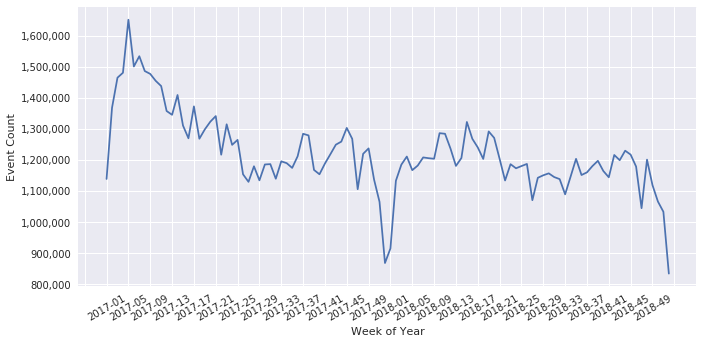

In [101]:
# group by week_year
data = counts_by_week_year(df_events)

# group by week and plot
x=data["YearWeek"]
y=data["Count"]

plot_line_over_time(x,y,"Event Count","All_Events_Counts")

### Plot trump mentions

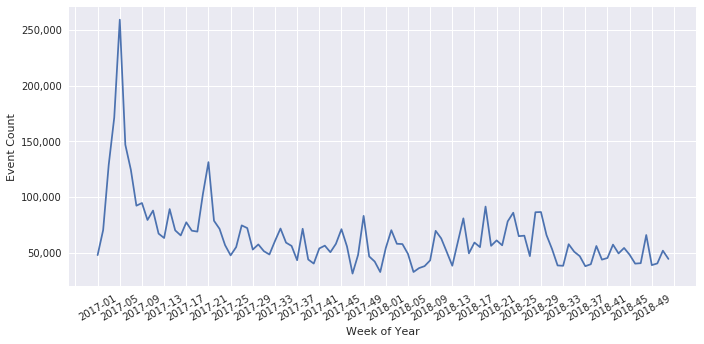

In [102]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('trump'))

# group by week_year
data = counts_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y=data["Count"]

plot_line_over_time(x,y,"Event Count","Trump_Events_Counts")

### Plot tariff mentions

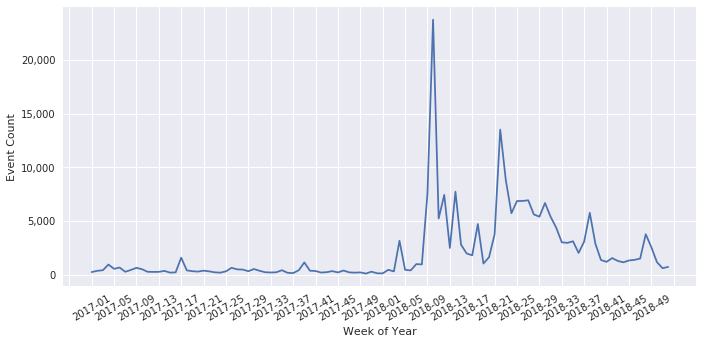

In [103]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('tariff')
                                  | df_events.SOURCEURL.rlike('trade*war'))

# group by week_year
data = counts_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y=data["Count"]

plot_line_over_time(x,y,"Event Count","Tariff_Events_Counts")

### Plot trump tone

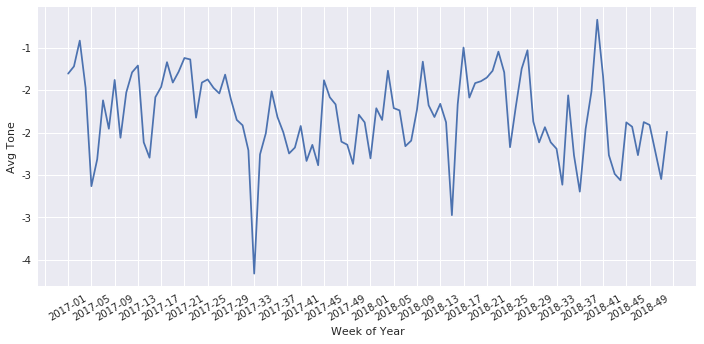

In [115]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('trump'))

# group by week_year
data = avg_tone_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y=data["AvgTone"]

plot_line_over_time(x,y,"Avg Tone","Trump_Events_Tone")

### Plot tariff tone

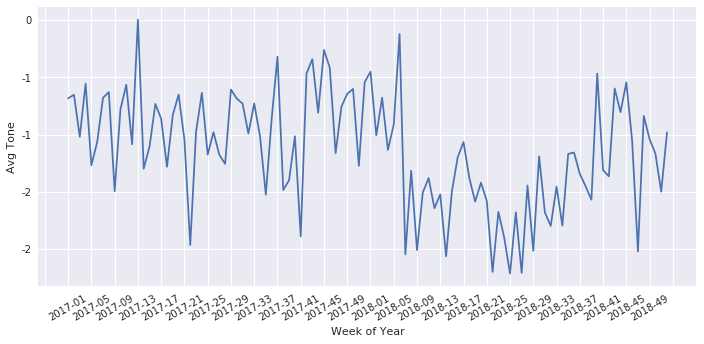

In [114]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('tariff')
                                  | df_events.SOURCEURL.rlike('trade*war'))

# group by week_year
data = avg_tone_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y=data["AvgTone"]

plot_line_over_time(x,y,"Avg Tone","Tariff_Events_Tone")

In [125]:
relevant_events = df_events.where(df_events.SOURCEURL.rlike('tariff')
                                  | df_events.SOURCEURL.rlike('trade*war')) #.select(["SOURCEURL"])
relevant_events.count()
#rec = pd.DataFrame(relevant_events.take(50))
#rec.columns = colnames_events
#rec

219153

In [ ]:
# Hilary's additions:

#### Plot Events where Trump makes threat

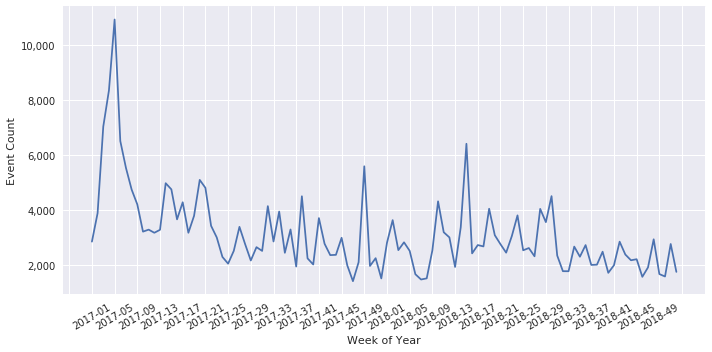

In [35]:
# get relevant events
relevant_events = df_events.where((df_events.EventCode.rlike('13') | df_events.EventCode.rlike('130') | df_events.EventCode.rlike('131'))
                                  & df_events.SOURCEURL.rlike('trump'))

# group by week_year
data = counts_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y=data["Count"]

plot_line_over_time(x,y,"Event Count","Trump_Threatens_Events_Counts")

#### Plot mentions of Trump and trariff or trade war

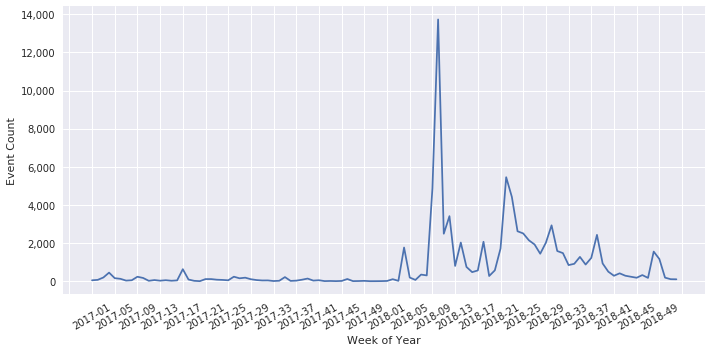

In [106]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('trump')).where(df_events.SOURCEURL.rlike('tariff') 
                    | df_events.SOURCEURL.rlike('trade*war'))

# group by week_year
data = counts_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y=data["Count"]

plot_line_over_time(x,y,"Event Count","Trump_Trade_Events_Counts")

#### First Trump tariffs - 22 Jan 2018, lots of activity March-Apr 2018

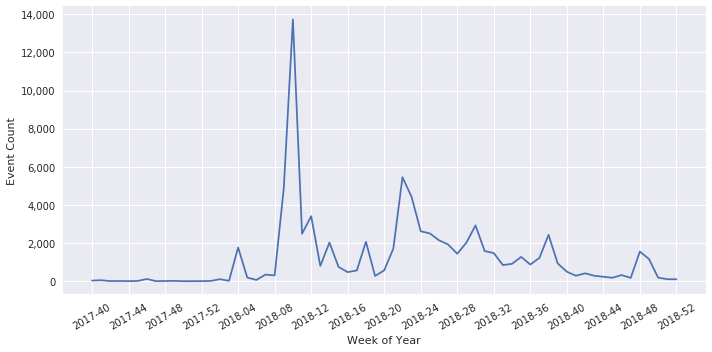

In [92]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('trump')).where(df_events.SOURCEURL.rlike('tariff') 
                                | df_events.SOURCEURL.rlike('trade*war')).where(col("MonthYear") >= 201710)

# group by week_year
data = counts_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y=data["Count"]

plot_line_over_time(x,y,"Event Count","Trump_Trade_Events_Counts")

### Subset of March-April 2018

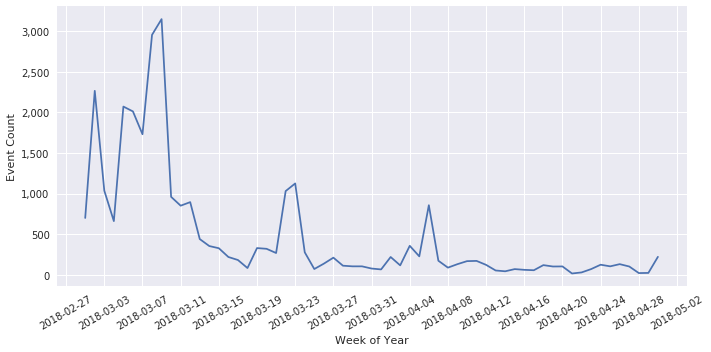

In [97]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('trump')).where(df_events.SOURCEURL.rlike('tariff') 
                                | df_events.SOURCEURL.rlike('trade*war')).where(col("MonthYear") >= 201803).where(col("MonthYear") <= 201804)

# group by week_year
data = counts_by_day(relevant_events)

# group by week and plot
x=data["Date"]
y=data["Count"]

plot_line_over_time(x,y,"Event Count","Trump_Trade_Events_Counts")

### China - Actor1

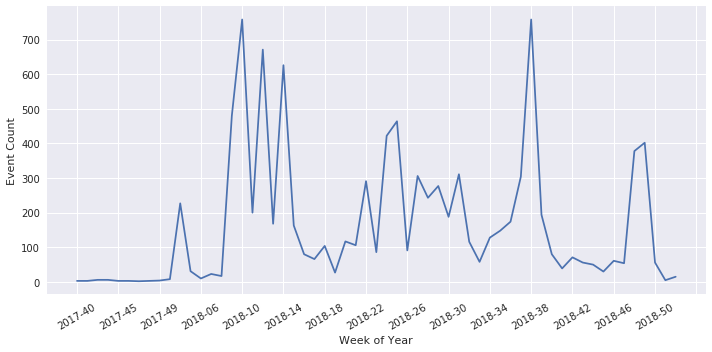

In [109]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('trump')).where(df_events.SOURCEURL.rlike('tariff')
                    | df_events.SOURCEURL.rlike('trade*war')).where(col("MonthYear") >= 201710).where(df_events.Actor1CountryCode.rlike('CHN'))

# group by week_year
data = counts_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y=data["Count"]

plot_line_over_time(x,y,"Event Count","Trump_Trade_Events_Counts")

### China - Actor2

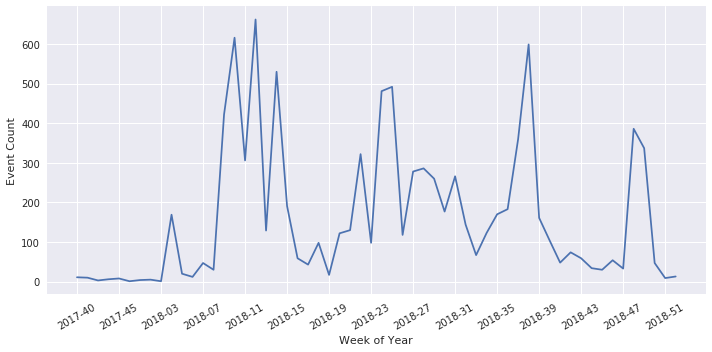

In [110]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('trump')).where(df_events.SOURCEURL.rlike('tariff')
                    | df_events.SOURCEURL.rlike('trade*war')).where(col("MonthYear") >= 201710).where(df_events.Actor2CountryCode.rlike('CHN'))

# group by week_year
data = counts_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y=data["Count"]

plot_line_over_time(x,y,"Event Count","Trump_Trade_Events_Counts")

### Mexico - Actor1

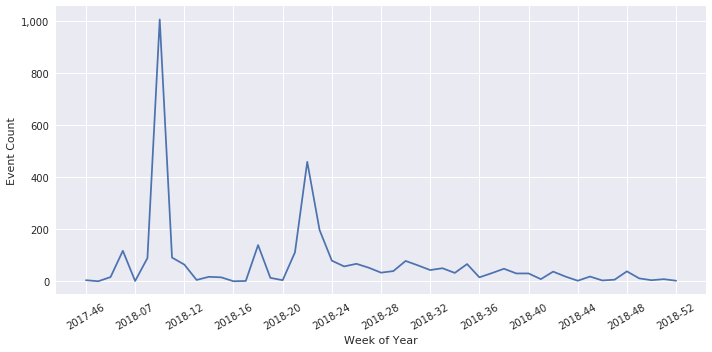

In [111]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('trump')).where(df_events.SOURCEURL.rlike('tariff')
                    | df_events.SOURCEURL.rlike('trade*war')).where(col("MonthYear") >= 201710).where(df_events.Actor1CountryCode.rlike('MEX'))

# group by week_year
data = counts_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y=data["Count"]

plot_line_over_time(x,y,"Event Count","Trump_Trade_Events_Counts")

### Mexico - Actor2

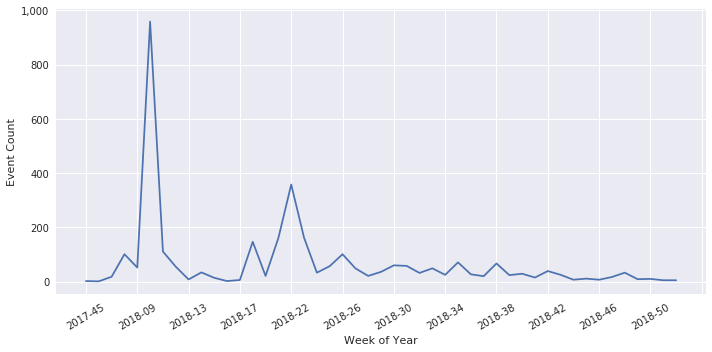

In [112]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('trump')).where(df_events.SOURCEURL.rlike('tariff')
                    | df_events.SOURCEURL.rlike('trade*war')).where(col("MonthYear") >= 201710).where(df_events.Actor2CountryCode.rlike('MEX'))

# group by week_year
data = counts_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y=data["Count"]

plot_line_over_time(x,y,"Event Count","Trump_Trade_Events_Counts")

In [ ]:
#  Codes for:
Canada CAN
Turkey TUR
India IND
South Korea KOR

#### Filters to find "Trump" in actor columns

In [75]:
# Count of number of URL's with Trump in 2018
relevant_events = df_events.where(df_events.SOURCEURL.rlike('trump')).where(col("Year") == 2018)
relevant_events.count()

2868093

In [76]:
# There are no records where the Actor1Name is filled in with "Trump", "trump", or "TRUMP"
# There aralso Actor2Name records, just none with "Trump"
relevant_events = df_events.where(df_events.Actor1Code.rlike('Trump'))
relevant_events.count()

0

In [78]:
# There are Actor1Name records, just none with "Trump"
relevant_events = df_events.where(df_events.Actor1Name.isNotNull())
relevant_events.count()

116055590

In [69]:
# Count records where Actor1 is identified as "Trump"
relevant_events = df_events.where(df_events.Actor1Code.rlike('%DONALD TRUMP%'))
relevant_events.count()

0

# Stop Spark Context

In [ ]:
sc.stop()